# Notebook: Hands-On Session – Introduction to Variational Autoencoder (VAE) with PyTorch


Variational Autoencoders are a class of generative models that learn a probabilistic mapping between an input space and a latent space. In contrast to standard autoencoders, VAEs impose a probabilistic structure on the latent space by learning parameters of a distribution (typically Gaussian) for each input.

In this session, we will build a VAE that learns to reconstruct MNIST digits.

In [1]:
import sys

if 'google.colab' in sys.modules:
    print("Running in Google Colab. Installing necessary packages...")
    !pip install torch torchvision torchaudio matplotlib seaborn torchinfo ipywidgets scikit-learn

In [2]:
import os
import time

import torch
import matplotlib
import torchvision
import numpy as np
import seaborn as sns
import torch.nn as nn
import ipywidgets as widgets
import torch.nn.init as init
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.nn import functional as F
from torch.utils.data import DataLoader
from IPython.display import Image, display
from torchvision import datasets, transforms, utils

sns.set()
sns.reset_orig()
%matplotlib inline
matplotlib.rcParams['lines.linewidth'] = 2.0

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = True

use_gpu = True
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
# device = torch.device("cpu")
print("Using device:", "GPU" if str(device)=='cuda' else device)

Using device: GPU


In [3]:
epochs = 100 #100
capacity = 64
latent_dims = 2
batch_size = 128
learning_rate = 1e-3
variational_beta = 1
DATASET_PATH = "./data" # Path to the folder where datasets are/should be downloaded (e.g. MNIST)
CHECKPOINT_PATH = "./saved_models/VAE" # Path to the folder where the model weights are to be saved

slurm_cpus = min(int(os.cpu_count()), 8)
NUM_WORKERS = max(1, slurm_cpus-1)

BREAK_TRAIN_EPOCH = 5

## Dataset

### Loading the MNIST Dataset

We will use the MNIST dataset for training our VAE. Each image is flattened to a 784-dimensional vector.

#Train dataset: 60000
#Test dataset: 10000


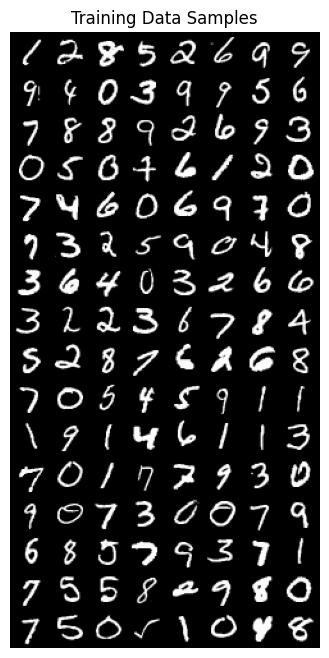

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST training dataset
train_dataset = datasets.MNIST(DATASET_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(DATASET_PATH, train=False, transform=transform)


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    drop_last=True,
    pin_memory=True,
    shuffle=True,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    drop_last=False,
    shuffle=False,
    pin_memory=True,
    num_workers=max(2, NUM_WORKERS//2),
    persistent_workers=True,
    prefetch_factor=2
)

print("#Train dataset:", len(train_dataset))
print("#Test dataset:", len(test_dataset))

# Visualize some training data samples
data_iter = iter(train_loader)
images, labels = next(data_iter)
grid_img = utils.make_grid(images, nrow=8)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('Training Data Samples')
plt.axis('off')
plt.show()


### Limitations of loss functions

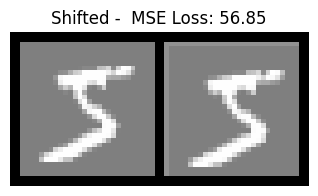

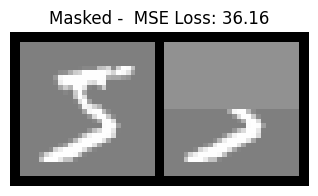

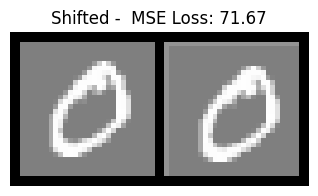

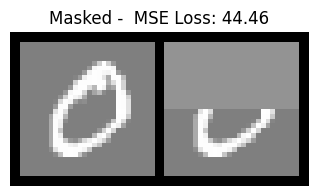

In [5]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix}  MSE Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## VAE Model Architecture

The model consists of:

- Encoder: A fully-connected network that outputs the parameters 𝜇 and log 𝜎^2 of the latent distribution.
- Reparameterization: A helper function to sample 𝑧 from the learned distribution.
- Decoder: A fully-connected network that reconstructs the input from the latent code.
We'll use a simple architecture appropriate for MNIST (images of size 28×28).

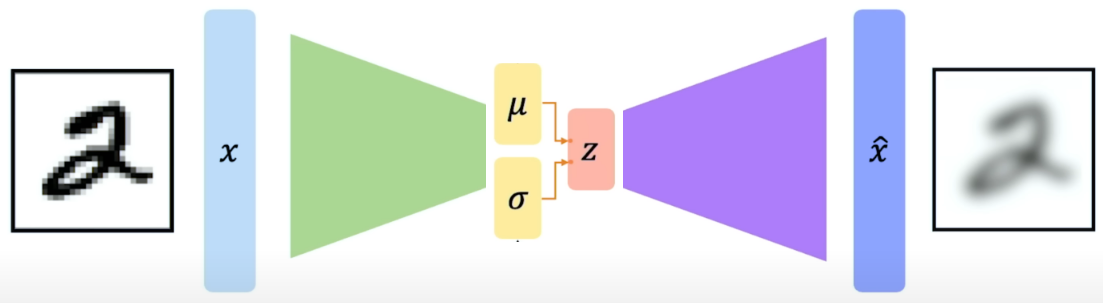

In [6]:
display(Image(filename="res/vae.png", width=800))

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar


In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.size(0), capacity*2, 7, 7)
        x = F.relu(self.conv2(x))
        x = self.conv1(x)
        return x
    

In [9]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def encode(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        return latent_mu, latent_logvar
        
    def decode(self, latent):
        x_recon = self.decoder(latent)
        return x_recon
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encode(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decode(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

### Weight Initialization in Deep Learning

Proper **weight initialization** is crucial for stable and efficient training of deep neural networks.  
If weights are too large, activations can explode; if too small, they can vanish—both leading to poor gradient flow and stalled learning.  
Good initialization (e.g., **Xavier** or **He initialization**) ensures that signals and gradients propagate at a healthy scale across layers,  
helping the model converge faster and achieve better performance.

In [10]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)

    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        init.ones_(m.weight)
        init.zeros_(m.bias)

def init_weights_vae(model):
    model.apply(init_weights)

    # Make final decoder conv (named conv1) smaller so sigmoid doesn't saturate 
    if hasattr(model.decoder, 'conv1'):
        w = model.decoder.conv1.weight.data
        w.mul_(0.01)  # scale down
        if model.decoder.conv1.bias is not None:
            model.decoder.conv1.bias.data.zero_()

    if hasattr(model.encoder, 'fc_logvar'):
        model.encoder.fc_logvar.bias.data.fill_(-4.0)

### VAE Loss (with β-VAE option)

A VAE optimizes **two coupled objectives**:

1. **Reconstruction loss** — how well the decoder rebuilds the input `x` from a latent sample `z`.  
   - **MSE** assumes Gaussian observation noise; it often produces **blurrier** images because it penalizes
     high-frequency differences, even if they’re perceptually minor.

2. **KL divergence** — regularizes the encoder’s posterior $q_{\phi}(z \mid x)$ to match the prior $p(z)=\mathcal{N}(0,I)$,
   encouraging a well-behaved latent space and enabling sampling:

$$
\mathrm{KL}\!\left(q_{\phi}(z \mid x)\,\|\,p(z)\right)
= -\tfrac{1}{2}\sum_{d}\Big(1+\log\sigma_{d}^{2}-\mu_{d}^{2}-\sigma_{d}^{2}\Big).
$$

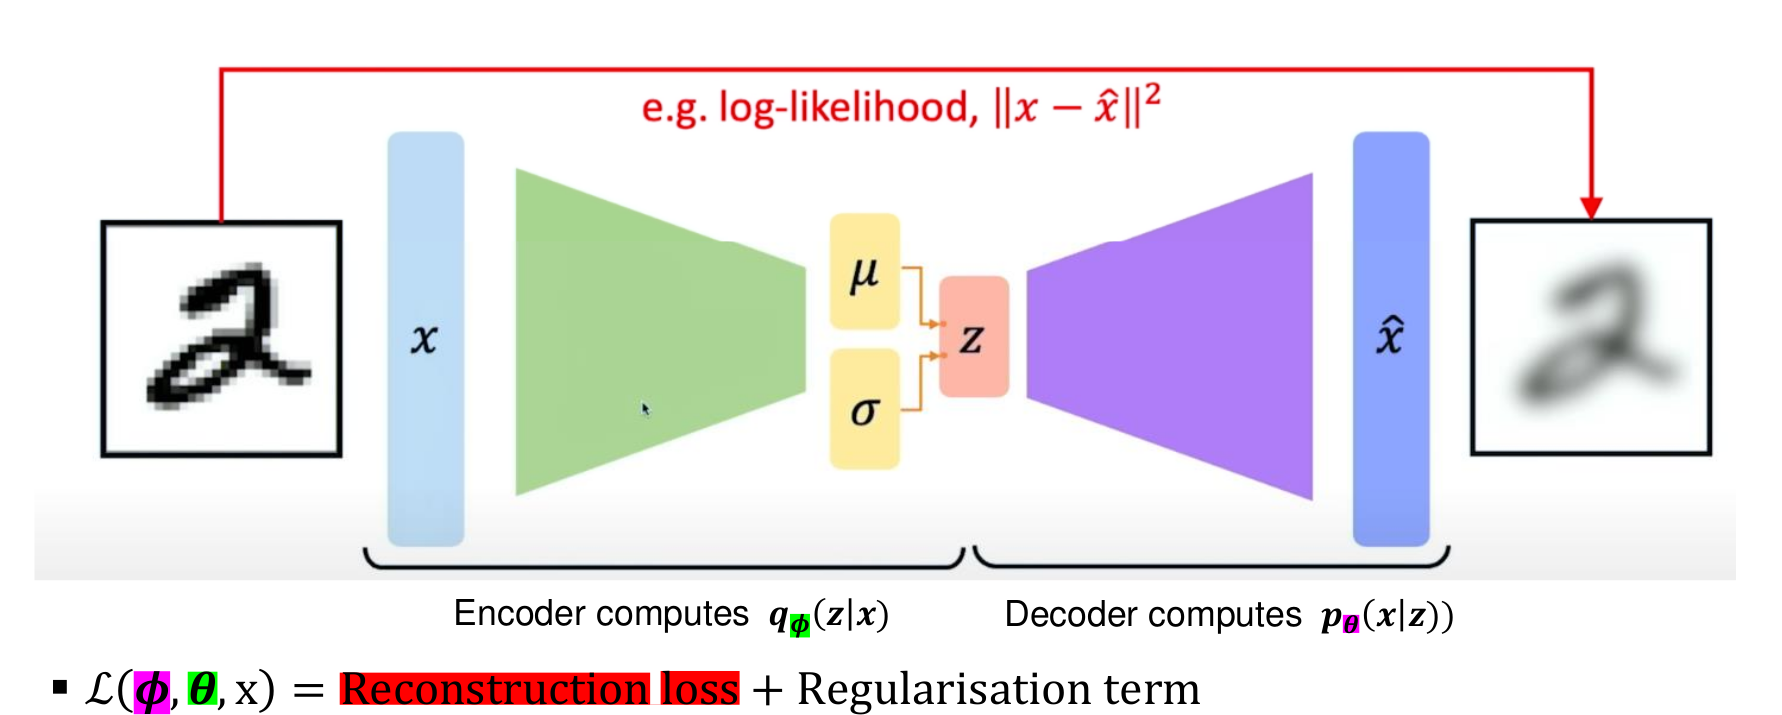

In [11]:
display(Image(filename="res/recon loss.png", width=800))

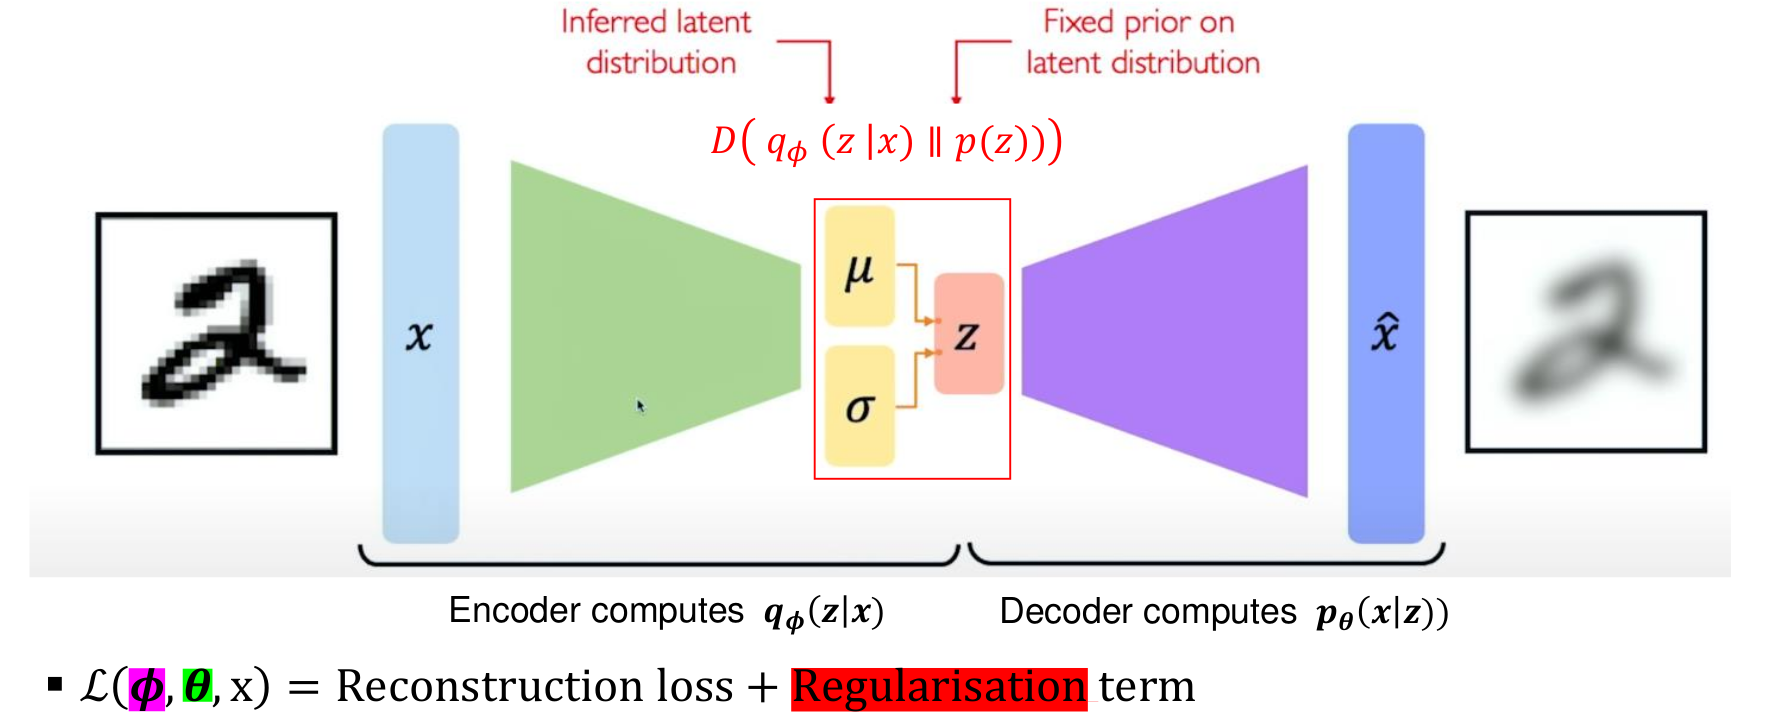

In [12]:
display(Image(filename="res/kl div loss.png", width=800))

In [13]:
bce_logits = nn.BCEWithLogitsLoss(reduction='sum')  # sum over pixels
def loss_function(recon_x, x, mu, logvar, variational_beta):
    batch_size = x.size(0)
    recon_loss = bce_logits(recon_x.flatten(start_dim=1), x.flatten(start_dim=1))
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + variational_beta * kldivergence)/batch_size


## Training

#### Training Loop with Loss Tracking

We now train the model while tracking both the training and validation losses for each epoch. These values will later be visualized to show how the training progresses. We use the Adam optimizer and train the model for several epochs. In each iteration, the loss is computed, backpropagated, and the model parameters are updated.

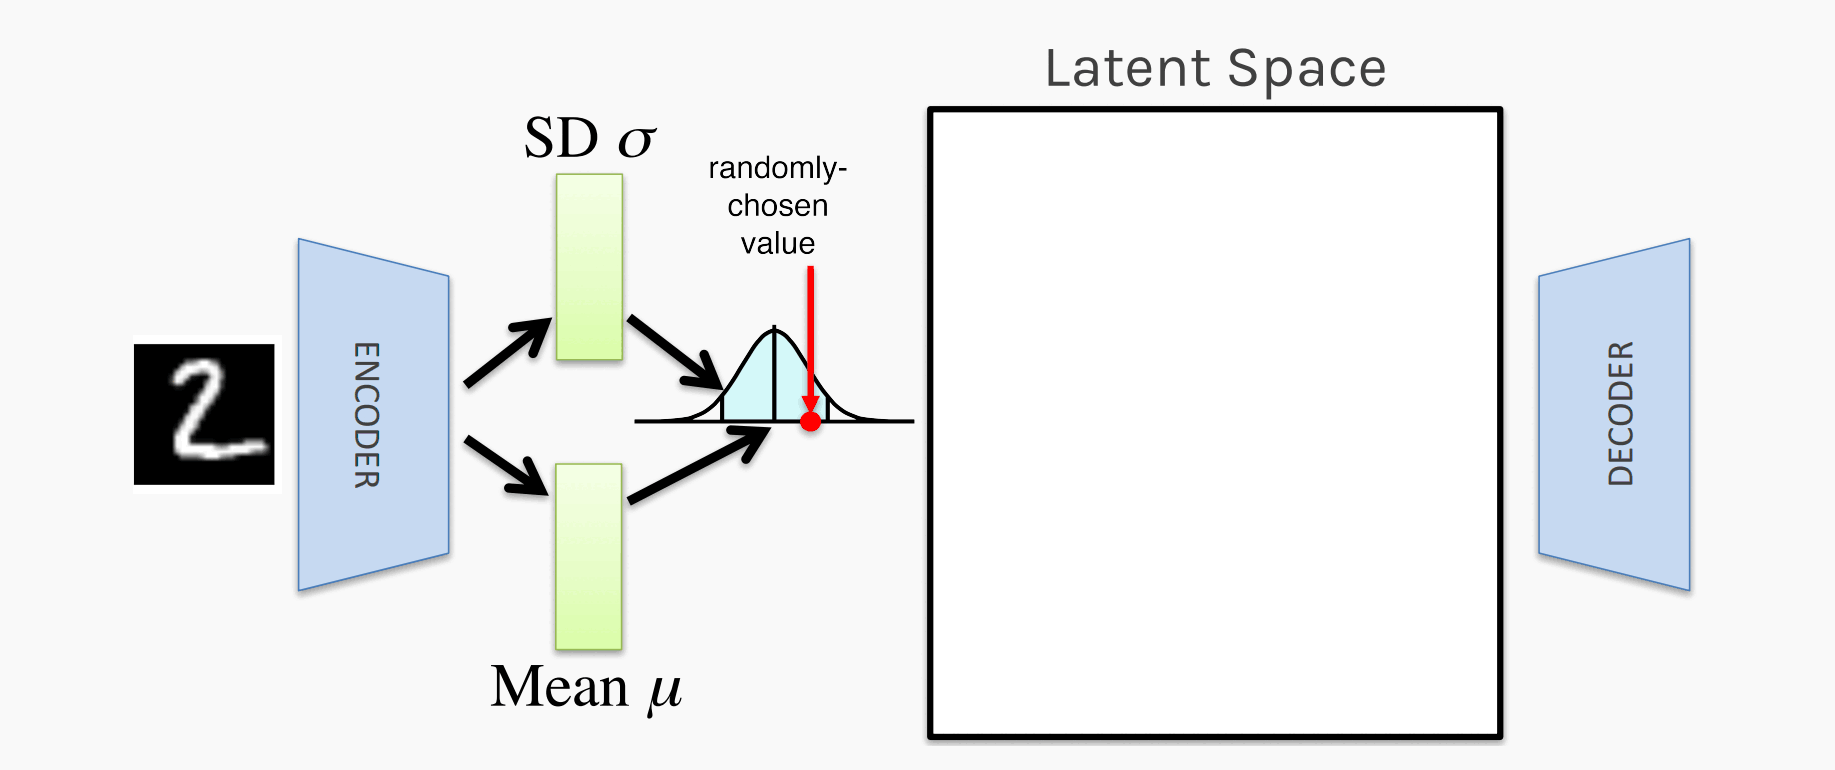

In [14]:
display(Image(filename="res/vae-train.gif", width=800))

In [15]:
vae = VariationalAutoencoder().to(device)
init_weights_vae(vae)
print("Model architecture")
print(summary(vae, input_size=(batch_size, 1, 28, 28), col_names = ['input_size', 'output_size', 'num_params', 'kernel_size', 'trainable'], device=str(device)) )
vae.to(memory_format=torch.channels_last)

# ------------- Optimizer -------------
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# ------------- Training loop -------------
def train_one_epoch(model, loader, optimizer, loss_beta):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for i, (data, _) in enumerate(loader):
        data = data.to(device)

        # Forward pass 
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar, loss_beta)

        # Backward + optimize
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.detach().cpu().item() 
        n_batches += 1

    return total_loss / max(1, n_batches)


def evaluate(model, loader, loss_beta):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            loss = loss_function(recon, data, mu, logvar, loss_beta)
            total_loss += loss.detach().cpu().item()
            n_batches += 1

    return total_loss / max(1, n_batches)


# ------------- Run training -------------
train_losses = []
val_losses = []
best_val = float('inf')
train_begin_time = time.time()
print(f"Model Training....")
for epoch in range(1, epochs+1):
    t0 = time.time()
    
    train_loss = train_one_epoch(vae, train_loader, optimizer, variational_beta)
    val_loss = evaluate(vae, test_loader, variational_beta)
    
    print(f"Epoch {epoch}/{epochs} — train_loss: {train_loss:.3f}, val_loss: {val_loss:.3f}, epoch_time: {time.time()-t0:.1f}s") #This slows down
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # checkpoint best
    # if val_loss < best_val:
    #     best_val = val_loss
    #     torch.save(vae.state_dict(), './pretrained/vae.pth')
        
    if epoch == BREAK_TRAIN_EPOCH:
        break
        
print(f"Training completed in: {time.time()-train_begin_time:.1f}s")

# load best checkpoint
vae.load_state_dict(torch.load('./pretrained/vae.pth'))
print(f"Best val_loss: {evaluate(vae, test_loader, variational_beta)}")

Model architecture
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
VariationalAutoencoder                   [128, 1, 28, 28]          [128, 1, 28, 28]          --                        --                        True
├─Encoder: 1-1                           [128, 1, 28, 28]          [128, 2]                  --                        --                        True
│    └─Conv2d: 2-1                       [128, 1, 28, 28]          [128, 64, 14, 14]         1,088                     [4, 4]                    True
│    └─Conv2d: 2-2                       [128, 64, 14, 14]         [128, 128, 7, 7]          131,200                   [4, 4]                    True
│    └─Linear: 2-3                       [128, 6272]               [128, 2]                  12,546                    --                        True
│    └─Linear: 2-4                       [128, 6272]               [128, 2] 

## PostProcessing

Generate various plots for understanding of the model architecture, latent space 

In [16]:
class PostTrainingVisualizations:
    def __init__(self, model, test_loader, train_losses, val_losses, epochs, latent_dim=latent_dims):
        self.model = model
        self.test_loader = test_loader
        self.train_losses = train_losses
        self.val_losses = val_losses
        self.epochs = epochs
        self.latent_dim = latent_dim
        self.device = next(model.parameters()).device 

    def loss_plot(self):
        """Visualisation of loss over epochs during training"""
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.epochs + 1), self.train_losses, label='Training Loss')
        plt.plot(range(1, self.epochs + 1), self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Curves')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def generate_samples(self, num_samples=64):
        """Randomly sample points from latent space and decode to generate images"""
        self.model.eval()
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(self.device)
            samples = self.model.decode(z).cpu()
            samples = torch.sigmoid(samples)
            
            grid_img = utils.make_grid(samples, nrow=8)
            plt.figure(figsize=(8, 8))
            plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
            plt.title('Generated Samples')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    def reconstruct_images(self, num_images=8):
        """Reconstruct the images"""
        self.model.eval()
        with torch.no_grad():
            data, _ = next(iter(self.test_loader))
            data = data.to(self.device)
            recon, _, _ = self.model(data)
            recon = torch.sigmoid(recon)

            plt.figure(figsize=(12, 4))
            for i in range(num_images):
                plt.subplot(2, num_images, i + 1)
                plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
                plt.axis('off')

                plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(recon[i].cpu().view(28, 28), cmap='gray')
                plt.axis('off')
            plt.suptitle('Top: Original Images | Bottom: Reconstructed Images')
            plt.tight_layout()
            plt.show()

    def visualize_latent_space(
        self,
        reduce: str = "auto",          # "auto" | "none" | "tsne"
        max_points: int = 20000,       # subsample for speed/clarity
        bins: int = 50,
        show_hist: bool = True,
        show_corr: bool = True,
        max_hist_dims: int = 10,
        pairplot: bool = True,
        pairplot_dims: int = 4,
        pairplot_subsample: int = 4000,
        standardize: bool = True,     # z-score each dim before hist/corr/pairplot
        cmap: str = "tab10"
    ):
        """
        latent visualization:
        - 2D scatter (raw 2D latents or TSNE if D>2 and reduce="auto"/"tsne")
        - Per-dimension histograms
        - Correlation heatmap
        """
        self.model.eval()
        Zs, Ys = [], []
        with torch.no_grad():
            for x, y in self.test_loader:
                x = x.to(self.device)
                _, mu, _ = self.model(x)             # (recon, mu, logvar)
                Zs.append(mu.detach().cpu().numpy())
                Ys.append(y.detach().cpu().numpy())
        Z = np.concatenate(Zs, axis=0)               # (N,D)
        y = np.concatenate(Ys, axis=0)               # (N,)
        N, D = Z.shape

        # Optional standardization (for hist/corr/pairplot comparability)
        Z_std = (Z - Z.mean(0, keepdims=True)) / (Z.std(0, keepdims=True) + 1e-8) if standardize else Z

        # Subsample for the main scatter if needed
        if max_points is not None and N > max_points:
            rng = np.random.RandomState(42)
            idx = rng.choice(N, max_points, replace=False)
            Z_plot = Z[idx]
            y_plot = y[idx]
        else:
            Z_plot, y_plot = Z, y

        # ---------- 1) Main 2D scatter ----------
        if D == 2 and reduce in ("auto", "none"):
            Z2 = Z_plot
            xlabel, ylabel, title = "z0", "z1", "2D Latent Space (μ)"
        else:
            if reduce in ("auto", "tsne"):
                Z2 = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto").fit_transform(Z_plot)
                xlabel, ylabel, title = "t-SNE dim 1", "t-SNE dim 2", "t-SNE of Latent Means"
            else:
                # If user forced "none" with D>2, fallback to first two dims
                Z2 = Z_plot[:, :2]
                xlabel, ylabel, title = "z0", "z1", "Latent (first 2 dims)"

        plt.figure(figsize=(8, 6))
        sc = plt.scatter(Z2[:, 0], Z2[:, 1], c=y_plot, s=10, alpha=0.7, cmap=cmap)
        cbar = plt.colorbar(sc)
        cbar.set_label("label")
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

        # ---------- 2) Histograms per dimension ----------
        if show_hist:
            k = int(min(max_hist_dims, D))
            cols = min(6, k)
            rows = int(np.ceil(k / cols))
            fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.0, rows * 2.4))
            axes = np.array(axes).reshape(rows, cols)
            Zk = Z_std[:, :k] if standardize else Z[:, :k]
            for i in range(rows * cols):
                ax = axes.flat[i]
                if i < k:
                    ax.hist(Zk[:, i], bins=bins, alpha=0.9)
                    ax.set_title(f"z[{i}]" + (" (std)" if standardize else ""))
                else:
                    ax.axis("off")
            fig.suptitle("Latent Dimension Histograms", y=0.995)
            plt.tight_layout()
            plt.show()

        # ---------- 3) Correlation heatmap ----------
        if show_corr:
            k = int(min(max_hist_dims, D))
            Zk = Z_std[:, :k] if standardize else Z[:, :k]
            corr = np.corrcoef(Zk, rowvar=False)  # (k,k)
            plt.figure(figsize=(k * 0.6 + 2, k * 0.6 + 2))
            im = plt.imshow(corr, vmin=-1, vmax=1, interpolation="nearest")
            plt.title("Latent Correlation (Pearson)")
            plt.colorbar(im, fraction=0.046, pad=0.04)
            plt.xticks(range(k), [f"z{i}" for i in range(k)], rotation=90)
            plt.yticks(range(k), [f"z{i}" for i in range(k)])
            plt.tight_layout()
            plt.show()

    def interpolate_images(self, index1, index2, num_steps=10):
        """Interpolate two randomly chosen points from prior along predefined number of points between them."""
        data, _ = next(iter(self.test_loader))
        if index1 >= len(data) or index2 >= len(data):
            print("Index out of range.")
            return
        
        data = data.to(self.device)
        img1, img2 = data[index1], data[index2]

        self.model.eval()
        with torch.no_grad():
            _, mu1, _ = self.model(img1.unsqueeze(0))
            _, mu2, _ = self.model(img2.unsqueeze(0))

        interpolation = torch.stack([mu1 * (1 - t) + mu2 * t for t in torch.linspace(0, 1, steps=num_steps)])
        with torch.no_grad():
            recon_images = self.model.decode(interpolation).cpu().view(-1, 1, 28, 28)
            recon_images = torch.sigmoid(recon_images)

        grid_img = utils.make_grid(recon_images, nrow=num_steps)
        plt.figure(figsize=(num_steps, 4))
        plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
        plt.title('Latent Space Interpolation')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def latent_variable_arithmetic(self, index1, index2, index3):
        """Apply latent arithmetic."""
        data, _ = next(iter(self.test_loader))
        if index1 >= len(data) or index2 >= len(data) or index3 >= len(data):
            print("Index out of range.")
            return

        data = data.to(self.device)
        img1, img2, img3 = data[index1], data[index2], data[index3]

        self.model.eval()
        with torch.no_grad():
            _, mu1, logvar1 = self.model(img1.unsqueeze(0))
            _, mu2, logvar2 = self.model(img2.unsqueeze(0))
            _, mu3, logvar3 = self.model(img3.unsqueeze(0))

        latent1 = self.model.latent_sample(mu1, logvar1)
        latent2 = self.model.latent_sample(mu2, logvar2)
        latent3 = self.model.latent_sample(mu3, logvar3)

        result_latent = latent1 - latent2 + latent3
        with torch.no_grad():
            recon_image = self.model.decode(result_latent).cpu().view(28, 28)
            recon_image = torch.sigmoid(recon_image)

        fig, axes = plt.subplots(1, 4, figsize=(6, 6))
        for idx, img, title in zip(range(4), [img1, img2, img3, recon_image], 
                                   ["Original 1", "Original 2", "Original 3", "Reconstructed"]):
            axes[idx].imshow(img.cpu().view(28, 28), cmap='gray')
            axes[idx].set_title(title)
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

    def plot_latent_manifold(self,
        device,
        n=20,
        xlim=None, ylim=None,          # None => auto from posterior μ
        padding=2,
        apply_sigmoid=True,
        overlay_loader=None,           # pass your test_loader to overlay μ
        overlay_max=5000,              # subsample overlay points
        cmap='gray'
    ):
        """Generation of samples from prior within a predefined grid."""
        vae = self.model
        vae.eval()

        # If xlim/ylim not given, estimate from aggregated posterior μ
        if xlim is None or ylim is None:
            zs = []
            if overlay_loader is None:
                raise ValueError("Provide xlim/ylim or overlay_loader for auto-range.")
            with torch.no_grad():
                for x, _ in overlay_loader:
                    x = x.to(device)
                    _, mu, _ = vae(x)            # model returns (recon, mu, logvar)
                    zs.append(mu.detach().cpu())
            Z = torch.cat(zs).numpy()
            # generous central range (1st–99th percentile)
            if xlim is None:
                xlim = tuple(np.quantile(Z[:,0], [0.01, 0.99]))
            if ylim is None:
                ylim = tuple(np.quantile(Z[:,1], [0.01, 0.99]))

        with torch.no_grad():
            xs = torch.linspace(xlim[0], xlim[1], steps=n)
            ys = torch.linspace(ylim[0], ylim[1], steps=n)
            gx, gy = torch.meshgrid(xs, ys, indexing='xy')    # shapes (n,n)
            z = torch.stack([gx, gy], dim=-1).reshape(-1, 2).to(device)

            xhat = vae.decoder(z)
            if apply_sigmoid:
                xhat = torch.sigmoid(xhat)
            xhat = xhat.clamp(0, 1).cpu()

            # tile into one big canvas
            grid = torchvision.utils.make_grid(xhat, nrow=n, padding=padding)  # (C,H,W)
            grid_np = grid.permute(1, 2, 0).numpy()
            if grid_np.shape[2] == 1:     # grayscale
                grid_np = grid_np[..., 0]

        fig, ax = plt.subplots(figsize=(8, 8))
        # origin='lower' so (xlim[0], ylim[0]) is bottom-left
        ax.imshow(grid_np, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], origin='lower', cmap=cmap)
        ax.set_title("Decoder manifold in latent space")
        ax.set_xlabel("z0")
        ax.set_ylabel("z1")
        ax.set_xticks(np.linspace(xlim[0], xlim[1], 5))
        ax.set_yticks(np.linspace(ylim[0], ylim[1], 5))

        # Optional: overlay posterior μ points from the dataset
        if overlay_loader is not None:
            pts, labs = [], []
            with torch.no_grad():
                for x, y in overlay_loader:
                    x = x.to(device)
                    _, mu, _ = vae(x)
                    pts.append(mu.detach().cpu())
                    labs.append(y)
                    if overlay_max and sum(p.shape[0] for p in pts) >= overlay_max:
                        break
            Z = torch.cat(pts)[:overlay_max].numpy()
            c = torch.cat(labs)[:overlay_max].numpy() if len(labs) else None
            ax.scatter(Z[:, 0], Z[:, 1], c=c, s=8, alpha=0.4, cmap='tab10', edgecolors='none')

        plt.tight_layout()
        plt.show()

In [17]:
viz = PostTrainingVisualizations(vae, test_loader, train_losses, val_losses, epochs, latent_dim=latent_dims)

#### 1. Loss Curve Visualization

This cell plots the training and validation loss curves, giving insight into how the model is learning over epochs.

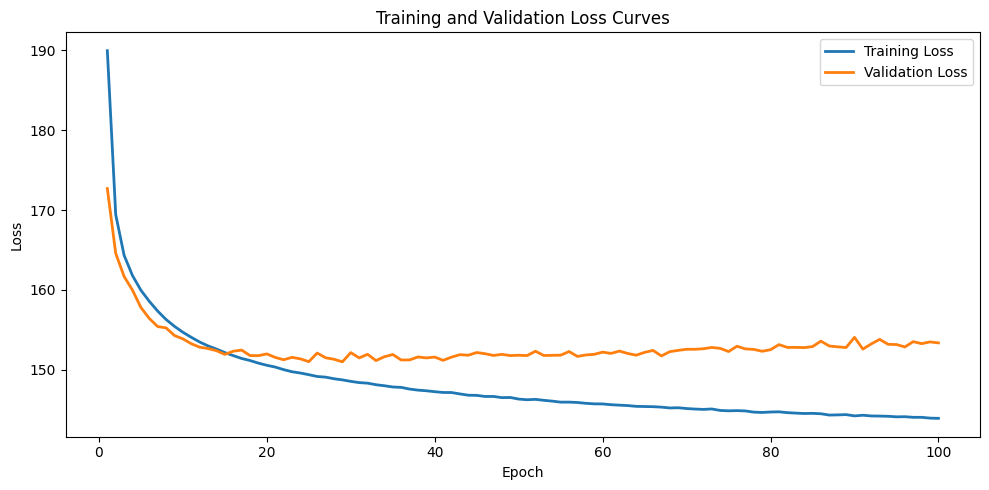

In [18]:
viz.loss_plot()

#### 2. Reconstruction Comparison

Let’s compare a few original images with their reconstructions from the VAE.

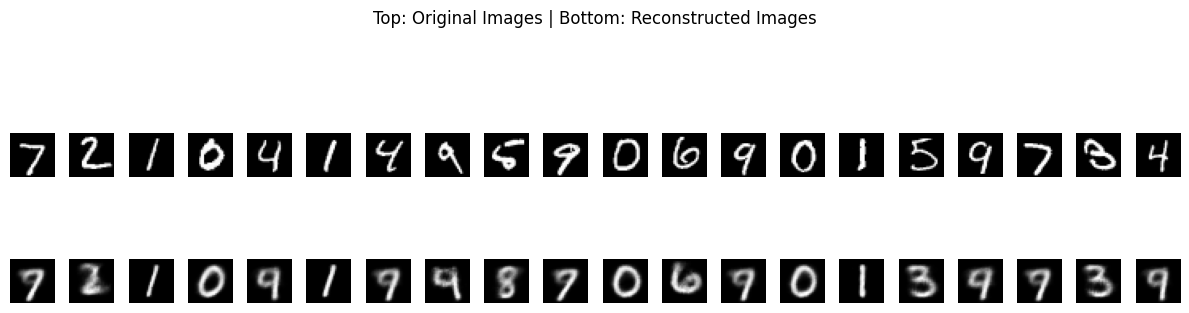

In [19]:
viz.reconstruct_images(num_images=20)

#### 3. Generating New Samples

After training, a VAE can act as a **generator**: we draw a latent vector `z` from the prior and pass it through the **decoder** to obtain a new image.

**How sampling works**
- **Prior sampling:** draw `z ∼ 𝒩(0, I)` and decode `x̂ = decoder(z)`.
- **Output domain:** if the decoder outputs the image.

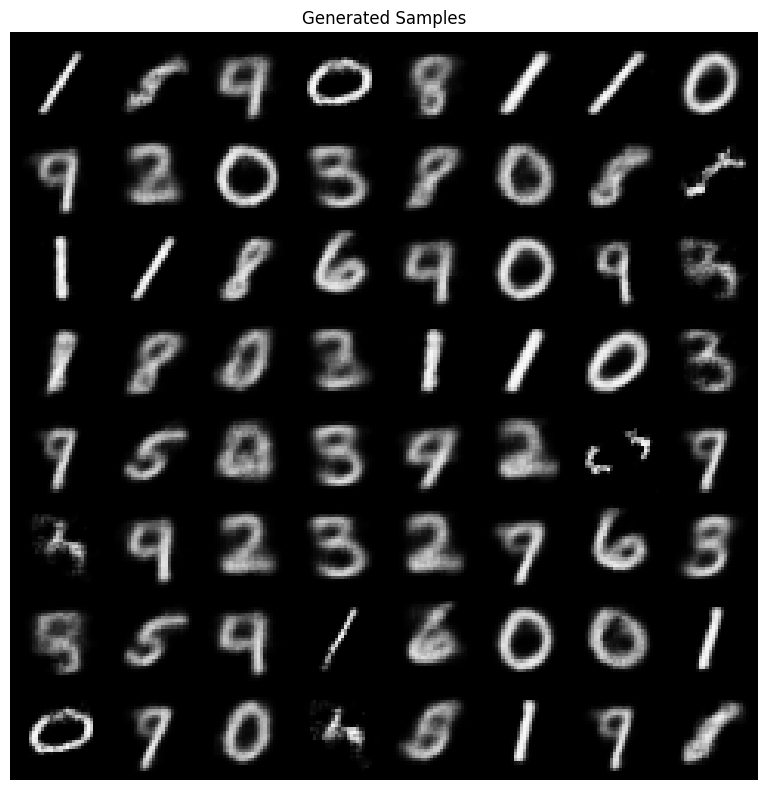

In [20]:
viz.generate_samples()

### 4. Latent Space Diagnostics (scatter + histograms + correlations + pair plot)

This visualization collects encoder means \( \mu \) for the test set and provides four views:

1. **Main 2-D scatter**
   - If latent dim = 2 → plots \((z_0, z_1)\).
   - If latent dim > 2 → uses **t-SNE** (or first two dims if chosen).
   - Points are colored by label to show class structure/separability.

2. **Per-dimension histograms**
   - Shape, center, and spread of each \( z_d \) reveal prior–posterior mismatch
     (e.g., means far from 0 or std ≠ 1 suggest misalignment with \( \mathcal{N}(0,I) \)).

3. **Correlation heatmap**
   - Pearson correlations across latent dimensions. Strong off-diagonals
     indicate redundancy / limited disentanglement.

4. **Pairwise scatter matrix**
   - Off-diagonal scatter for selected dims; diagonal shows histograms.
   - Useful for spotting clusters, nonlinear relations, and outliers.

**How to read**
- **Tight, separated clusters** → informative latents.
- **Global shift/scale** → prior mismatch (sampling may degrade).
- **High correlations** → entangled factors; consider TC/β-VAE variants.
- **Sparse/outlier regions** → off-manifold areas likely decode poorly.


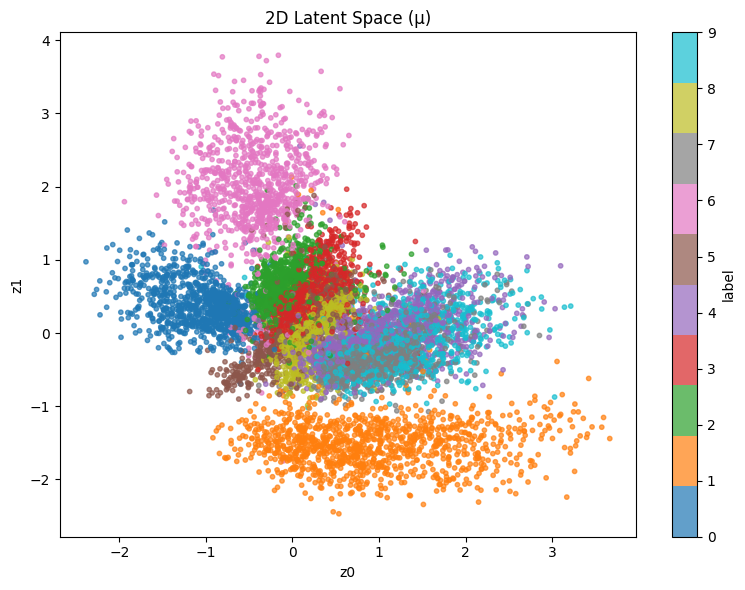

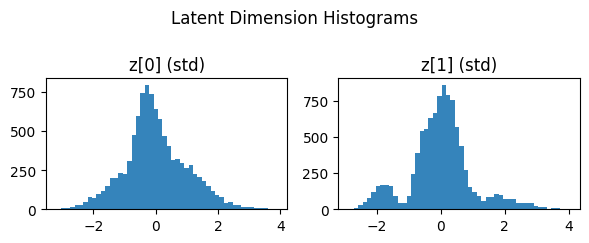

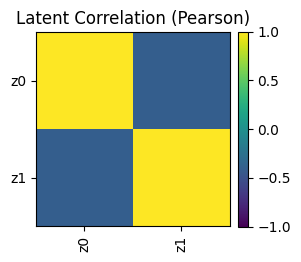

In [21]:
viz.visualize_latent_space()

### 5. Latent Space Interpolation

**Goal:** Demonstrate that the latent space is (approximately) smooth by taking two points in latent
space (by randomly sampling from prior), and decoding a sequence of interpolated latent codes to visualize a gradual morph.

**Steps**
1. Pick two points \(x_a, x_b\).
3. Interpolate between them:
   - **Lerp (linear):** \( z_t = (1-t)\,\mu_a + t\,\mu_b \)
4. Decode each \(z_t\) to get intermediate images and tile them in order.

**Interpretation**
- **Smooth transitions** suggest a well-structured latent geometry.
- **Artifacts or jumps** often indicate off-manifold regions or prior–posterior mismatch.


In [22]:
widgets.interact_manual(viz.interpolate_images,
                 model=widgets.fixed(vae),
                 index1=widgets.IntSlider(value=0, min=0, max=9, step=1, description='Image 1', continuous_update=False),
                 index2=widgets.IntSlider(value=1, min=0, max=9, step=1, description='Image 2', continuous_update=False),
                 num_steps=widgets.IntSlider(value=10, min=5, max=20, step=1, description='Steps', continuous_update=False),)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image 1', max=9), IntSlider(val…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### 6. Latent Variable Arithmetic

**Objective.** Show that simple vector arithmetic in the latent space can induce **semantically coherent** changes in decoded images.

**Idea.** Sample 3 points from latent space `(A, B, C)` and form
$$
z_{\text{result}} = \mu_A - \mu_B + \mu_C,
$$
then decode \(z_{result}\). If the latent space is well-structured, the decoded image reflects “A without what B had, plus what C had”.

**Why this can work (and limits).**
- VAEs encouraged toward a smooth, locally linear latent geometry; linear moves can map to consistent semantic edits.
- Works best when latents are **well-regularized** (e.g., suitable \(\beta\), KL scheduling) and relatively **disentangled**.
- Not guaranteed: arithmetic may fail if factors are entangled or the move leaves the **data manifold**.

In [23]:
widgets.interact_manual(
    viz.latent_variable_arithmetic,
    index1=widgets.IntSlider(0, 0, 9, 1, description='Image 1', continuous_update=False),
    index2=widgets.IntSlider(1, 0, 9, 1, description='Image 2', continuous_update=False),
    index3=widgets.IntSlider(1, 0, 9, 1, description='Image 3', continuous_update=False),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image 1', max=9), IntSlider(val…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### 7. Decoder Manifold (20×20 Grid)

This plot shows a **20×20 grid of images decoded from a 2-D latent space**.

Latent codes \( z = (z_0, z_1) \) are sampled uniformly over the range \([-1.5, 1.5]^2\).  
Each point in this grid is passed through the **VAE decoder**, and the resulting images are tiled such that:

- The **horizontal axis** corresponds to \( z_0 \)
- The **vertical axis** corresponds to \( z_1 \)

**Interpretation:**  
Smooth transitions across the grid indicate a well-organized latent space, where nearby points in the latent space produce similar outputs.  
Regions with blurry or unrealistic images (often near the edges) suggest areas of latent space that were under-represented during training.


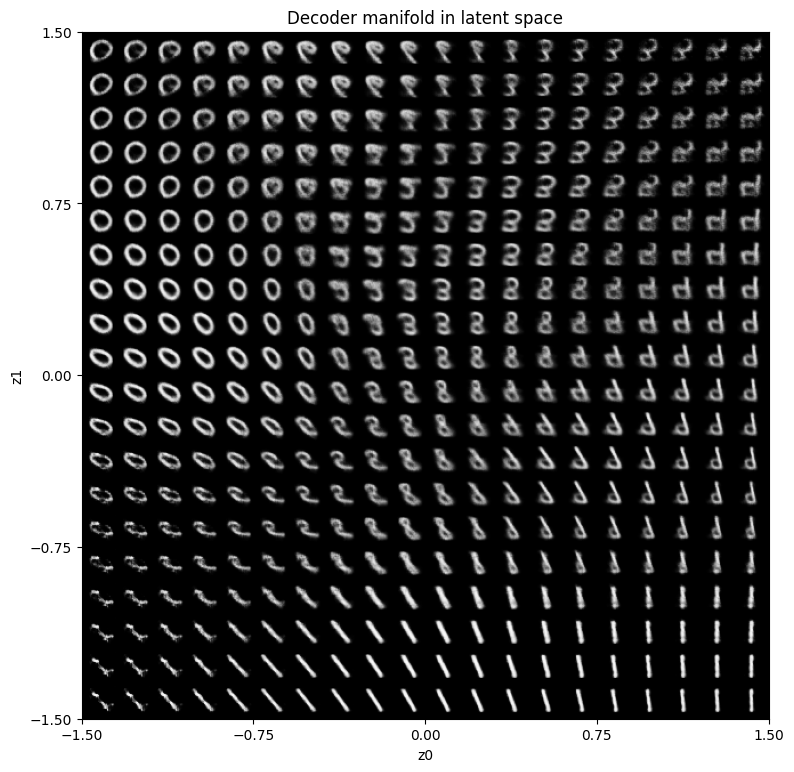

In [24]:
# Simple: fixed range
viz.plot_latent_manifold(device, n=20, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), overlay_loader=None)

# Summary

In this notebook, we:

- Built a simple VAE model in PyTorch.
- Trained the model on the MNIST dataset.
- Visualized both newly generated samples and the reconstruction quality on test images.